#### LEBRAT Timothée - TOLLET Gaëtan - TUDÈS Paul

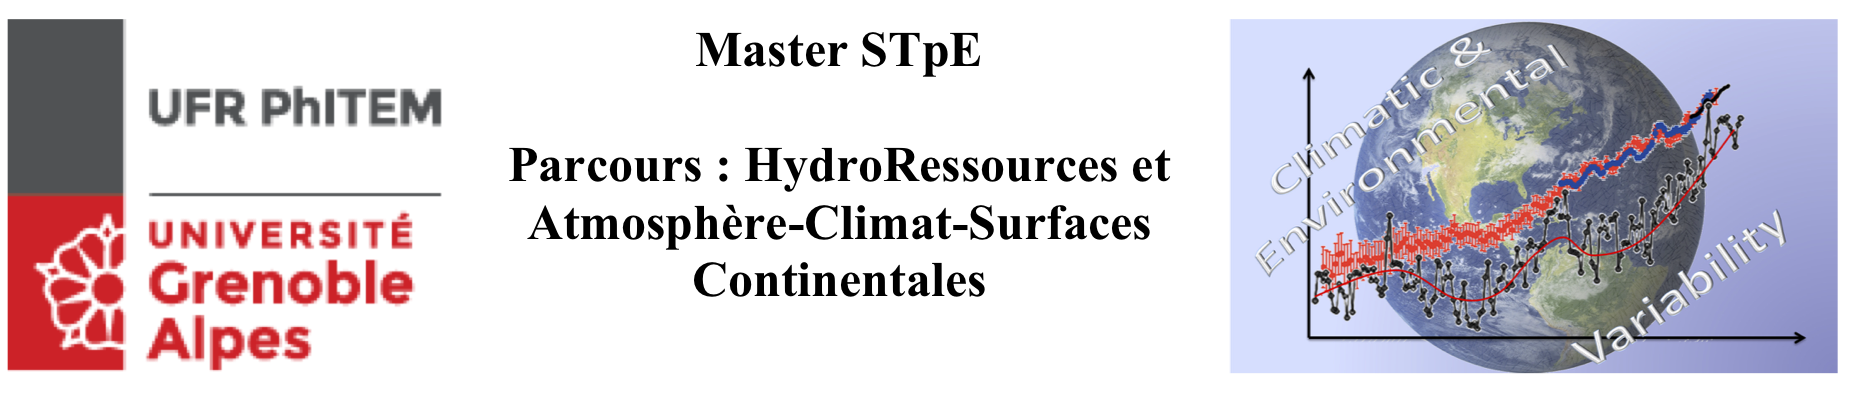


# Analyse statistique du manteau neigeux du col du Lautaret

## Introduction :

>Notre étude exploratoire sur la neige du Lautaret est un s’appuie sur l’exploitation des données de deux stations de mesures, FluxAlp qui est installée dans le pré des Charmasses, et ROMMA qui est installé sur le site du jardin du Lautaret.  

>En plus de récolter des mesures météorologiques (Température, pression, vent) la station Flux Alp est équipée depuis 2012 de capteurs permettant d’apprécier des paramètres physiques et environnementaux : Hauteur de neige, Albedo, Humidité du sol, Indice NDVI, Net Long-wave Radiation.

>Nous avons également accès aux données SAFRAN de Météo France, il s’agit d’un modèle de prévision météo, permettant d’obtenir une analyse horaire (température, vent, humidité, précipitations, nébulosité) et des données de rayonnement (infrarouge et visible).

>Conscients que les Alpes font partie des régions les plus touchées par le changement climatique, nous nous sommes naturellement rapprochés de ce sujet. Ce rapport exploratoire va donc porter sur l’étude de la neige et des variables qui lui sont associées. Notre objectif premier est de caractériser le vieillissement de la neige grâce à la mesure de l’Albedo, dans un second temps nous avons également essayé de détecter les évènements de dépôts de poussière saharienne, et de quantifier l’impact de ces évènements sur la neige.  En effet, la majorité des aérosols augmentent l'absorption de l'énergie solaire dans les longueurs d'onde visibles, il en résulte ensuite un changement des propriétés de la neige qui diminuent davantage l'albédo.

>Dans un premier temps nous allons faire une analyse descriptive de nos données. Nous expliquerons ensuite la méthode utilisée sans détailler le script Python, mais en exposant les limites que nous avons rencontrées. Enfin nous présenterons les résultats obtenus, ainsi que nos observations et interprétations.

## Situation géographique :

>Le jardin du Lautaret est situé à 2100 mètres d'altitude au col du Lautaret dans les Hautes-Alpes, à la limite des entre les Alpes du Nord et les Alpes du Sud, caractérisé par des climats très différents avec une influence océanique entrainant de fortes précipitations au Nord et un fort ensoleillement sous influence méditerranéenne au Sud.


# I - Set Up et initialisation des fonctions

Dans cette partie nous initialisons toutes les fonctions qui seront, par la suite, utilisée dans ce Notebook.


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from scipy import stats
from scipy.integrate import quad
import shutil, os

In [2]:
def New_df(name_df, col_liste, liste_resample, name_new_df, operation = 'mean'):
    
    """
    Cette fonction permet de selectionner certaines colonnes d'un DataFrame et de les assembler en jour/mois/...
    Elle va venir créer des différents df. Le premier sera la copie du df originel avec seulement les colonnes 
    souhaitées. Les autres seront définis en fonction de la liste de resample.
    
    .    Elle prend en argurment :
    .
    .          name_df : Le DataFrame à utiliser
    .          col_liste : Une liste des colonnes à selectionner, la colonne date est selectionnée par défaut
    .          liste_resemple : Une liste des resample à effectuer : 'd','m','a' ...
    
    .          name_new_df : Le nom des nouveaux DataFrame créés. Ils seront sauvegardés dans personnal_data
               --> Attention, ne pas mettre ni l'année ni .csv dans ce nouveau nom.
               Simplement mettre la racine commune pour les X nouveaux DataFrame
               
    .          operation : ('mean' ou 'sum' ou 'min_max' ou 'mean_sum')
                            - mean : fait la moyenne pour le resample donné : par défaut.
                            - sum : fait la sum pour le resample donné
                            - min_max : fera la moyenne de la colonne 1 pour le res donné, cherchera
                              la plus petite valeur dans la colonne 2 pour le res donné 
                              et la plus grande dans la colonne 3 pour le res donné.
                            - mean_sum : fera la moyenne de la colonne 1 pour le res donné
                              et la sum de la colonne 2 pour le res donné.
    
    Cette fonction renvoie également une liste des noms des différents df créés.
    """
    df = name_df
    liste_name_df = []
    new_df = df[col_liste]
    """
    Mise en index des dates
    """
    new_df.set_index(df['date'], inplace = True) 
    """
    Transformation des dates str en dates utilisables
    """
    index = new_df.index
    index_date = pd.to_datetime(index, dayfirst = True)
    new_df = new_df.set_index(index_date) 
    """
    Sauvegarde de la copie du fichier originel avec seulement les colonnes souhaitées
    """
    new_df.to_csv('../personnal_work/personnal_data/'+name_new_df+'.csv', sep = ';') 
    liste_name_df.append(name_new_df+'.csv')
        
    for res in liste_resample : 
        if operation == 'min_max' :

            moyenne = new_df[col_liste[0]].resample(res).mean()
            df_moyenne = pd.DataFrame(moyenne)
            minus = new_df[col_liste[1]].resample(res).min()
            df_minus = pd.DataFrame(minus)
            maxi = new_df[col_liste[2]].resample(res).max()
            df_maxi = pd.DataFrame(maxi)

            """je joints les 3 colonnes créées en un seul df : df_resample"""

            df_transit = df_moyenne.join(df_minus) 
            df_resample = df_transit.join(df_maxi)

         
        if operation == 'mean' : df_resample = new_df.resample(res).mean()
        if operation == 'sum' : df_resample = new_df.resample(res).sum()
        
        if operation == 'mean_sum' : 
            moyenne = new_df[col_liste[0]].resample(res).mean()
            df_moyenne = pd.DataFrame(moyenne)
            somme = new_df[col_liste[1]].resample(res).sum()
            df_somme = pd.DataFrame(somme)
            
            df_resample = df_moyenne.join(df_somme)

        df_resample.to_csv('../personnal_work/personnal_data/'+name_new_df+'_'+res+'.csv', sep = ';')
        liste_name_df.append(name_new_df+'_'+res+'.csv')
            
    return liste_name_df

In [3]:
def divise_année(name_df, annee_debut, annee_fin, name_new_df=None, divise_hiver = None):
    
    """
    Cette fonction permet de diviser automatiquement n'importe quelle donnée du tableau en X nouveaux
    DataFrame annuels.
    
    .    Elle prend en argument : 
    .                 
    .          name_df : Quel DataFrame utiliser (str). Elle s'occupe de le trouver et de l'ouvir.
               ATTENTION : ne pas mettre .csv
    .          annee_debut : L'année de début de l'échantillionnage.
    .          anne_fin : L'année de fin de l'échantillionnage.
    .          name_new_df : Le nom que nous voulons donner au DataFrame (str). 
               Par défaut : None -> le nom sera celui du DF ouvert + l'année.
               --> Attention, ne pas mettre ni l'année ni .csv dans ce nouveau nom.
               Simplement mettre la racine commune pour les X nouveaux DataFrame.
    .          divise_hiver : paramètre uniquement utilisé pour l'albédo. Ceci permet de ne pas diviser par
               année mais par hiver. Par défaut None -> donc la fonction divise par défaut par année.
    
    Cette fonction renvoie également une liste des noms des différents df créés pour pouvoir les stocker.
    """
    
    liste_name_df = []
    
    chemin = '../personnal_work/personnal_data/'+name_df+'.csv' 
    
    df = pd.read_csv(chemin, sep= ';', parse_dates = True, index_col = 0)
    
    for i in range(annee_debut,annee_fin):
    
        annee = str(i) 
        date = ['01-01','12-31']
        new_df = df[annee+'-'+date[0]:annee+'-'+date[1]]
        if divise_hiver : 
            date = ['12-01','04-30']
            annee2 = str(i+1)
            new_df = df[annee+'-'+date[0]:annee2+'-'+date[1]]
        if name_new_df : name_df = name_new_df
        chemin = '../personnal_work/personnal_data/'+name_df+'_'+annee+'.csv'
        new_df.to_csv(chemin,sep =';')
        
        liste_name_df.append(name_df+'_'+annee+'.csv')
    return liste_name_df

In [4]:
def Graph(name_df, x_units, y_units, y2_units=None, x_min=None, x_max=None, y_min=None, y2_min=None, 
          y_max=None, y2_max=None, deux_ax=False, title=None, l_title=None, legend=True, start_year=2010, 
          columns='all', col_lissage=None, val_lissage=8, csv=True, plusieurs_graph=False, save=None, 
          autre_graph=None):

    """
    Cette fonction permet de tracer nos graphique sans ré-écrire tout le code.
    
    .    Elle prend en argument :
    .          
    .          name_df : Le nom du DataFrame à tracer en str sous forme de liste sans oublier le .csv. 
                         Elle s'occupe de le trouver dans l'arborescence.
                         Si il y a plusieurs graphiques à tracer à partir de plusieurs DF cette variable prend
                         la liste des noms str des DF à utiliser.
    .          x_units : Les unités des abscisses 
    .          y_units : Les unités des ordonnées
    .          y2_units : Les unités des ordonnées si il y a un deuxième axe.
    .          x_min : Valeur x_min dans x_lim. Par défaut None, x_min renvoie alors la valeur definie par le plot.
    .          x_max : Valeur x_max dans x_lim. Par défaut None, x_max renvoie alors la valeur definie par le plot.
    .          y_min : Valeur y_min dans y_lim. Par défaut None, y_min renvoie alors la valeur definie par le plot.
    .          y2_min : Valeur y2_min dans y2_lim. Par défaut None.
    .          y_max : Valeur y_max dans y_lim. Par défaut None, y_max renvoie alors la valeur definie par le plot.
    .          y2_max : Valeur y2_max dans y2_lim. Par défaut None.
    .          deux_ax : Permet de mettre un deuxième axe sur un graphique avec deux courbes. 
               --> Attention ne marche QUE si il y a 2 courbes, pas plus, pas moins. Peut néanmoins prendre 
               une ou deux courbes de lissages. Également, il faut bien penser à mettre les noms des colonnes dans
               le même ordre pour le traçage et le lissage.
    .          title : Le titre du graphique en str. Par défaut None
    .          l_title : la liste des titres des graphique en stre, si cette dernière ne peut pas se faire en 
               ajoutant simplement la date du dataframe. Utilisé dans le cas de boxplot par exemple.
    .          legend : Permet d'afficher la légende. Par défaut : True. Pour enlever la légende : False
    .          start_year : pour l'initialisation des dates dans les noms des graphs. Par défaut 2010
               
    .          columns : Quelles sont les colonnes du DF à tracer (liste de str). Par défaut all -> rien à mettre.
               Sinon on met simplement le nom des colonnes souhaitées en str. 
               Attention, la colonne date est mise en abscisse par défaut, ne pas la rajouter dans "columns".
               
    .          col_lissage : Prend le ou les nom(s) (liste de str) de la ou des colonnes du DF que 
               nous voulons lisser. Par défaut : None -> pas de courbe de lissage
    .          val_lissage : Prend la valeur de la fenetre de lissage (window). Par défaut : 8  
    
    .          csv : Si le fichier est un fichier sauvegardé en tant que csv(=True). Si il est contenu dans une 
               variable déjà appelée dans le Notebooks (=False).
               
    .          plusieurs_graph : Si name_df est une liste = True. Sinon = False (par défaut). 
               Permet de tracer tous les graphs dans une même fenêtre.
               
    .          save : Permet de sauver notre plot. Il faut lui renvoyer le nom de notre sauvegarde en str.
               Par défaut : None -> pas de sauvegarde.
    .          autre_graph : Prend le type du nouveau graph('pie' OU 'hist' OU 'boxplot'). Par défaut None
                            
                            pie = graphique en camembert (ici fait la somme des precip solid/liquid par an)
                            ATTENTION: pour que autre_graphe marche la condition "columns" ne doit pas etre all
                            (Je ne sais plus pk ... je vais chercher. Bref mets la liste des colonnes que tu veux 
                            tracer.)
                            
                            hist : hist permet de tracer l'histogramme du DataFrame à condiction que columns 
                            ne contienne qu'une seule colonne.
                            ATTENTION : l'utilisation de hist n'est pas compatible avec plusieurs_graph ni 
                            lissage. 
                            
                            boxplot : permet de tracer des boxplot à partir d'une liste de dataframe.
    """
    l_color = ['b','darkorange','r', 'green']
    r=0
    if plusieurs_graph : plt.figure(figsize=(len(name_df)*10,len(name_df)*10))
    i = 1
    for name in name_df :
        if csv : 
            chemin = '../personnal_work/personnal_data/'+name
            df = pd.read_csv(chemin, sep= ';', parse_dates = True, index_col = 0)

        else : df = name
            
        if col_lissage is not None :
            l_liss_col = []
            for col in col_lissage :
                liss = df[col].rolling(window=val_lissage, center=True).mean()
                df = df.assign(x = liss)
                name_col = 'lissage_'+str(col)
                df.rename(columns = {'x': name_col}, inplace = True)
                l_liss_col.append(name_col)

        plt.subplot(len(name_df),len(name_df),i)
        
        if columns != 'all':
            if col_lissage is not None : 
                l_col = []
                for col in columns :
                    l_col.append(col)
                for col in l_liss_col :
                    l_col.append(col)
                df = df.loc[:, l_col]
            else : df = df.loc[:, columns]
 
        if deux_ax :
            plt.plot(df[columns[0]], label = df.columns[0])
            plt.legend(loc=2)
            if col_lissage is not None :
                plt.plot(df[l_liss_col[0]], color = l_color[2], label = l_liss_col[0])
                plt.legend(loc=2) 
       
        if autre_graph == 'hist' : plt.hist(df, bins=len(list(df.iloc[:,0])))
            
        if autre_graph == 'boxplot' :
            df.boxplot()
            r=45
            
        if (autre_graph == 'pie' or autre_graph is None) and deux_ax is False :
            plt.plot(df)
            if legend is True : plt.legend(df)
        
        if plusieurs_graph is True and title is not None : plt.title(title+'_'+str(start_year-1+i))
        else : plt.title(title)
            
        if l_title : plt.title(l_title[i-1])
         
        plt.xlim(x_min,x_max)
        plt.ylim(y_min,y_max)
        plt.xlabel(x_units)
        plt.xticks(rotation = 45+r)
        plt.ylabel(y_units)
        plt.grid()
        
        if deux_ax :
            ax2 = plt.twinx()
            ax2.set_ylabel(y2_units)
            ax2.set_ylim(y2_min,y2_max)
            ax2.plot(df[columns[1]], label = df.columns[1], color = l_color[1],)
            ax2.legend(loc=1)
            ax2.grid()
            if col_lissage is not None and len(l_liss_col) == 2 :
                ax2.plot(df[l_liss_col[1]], color = l_color[3], label = l_liss_col[1])
                ax2.legend(loc=1)        
        
        if autre_graph == 'pie':
            l_val = []
            l_col = []
            for col in columns :
                val = df[col].sum()
                l_val.append(val)
                l_col.append(col+'='+str(round(val))+y_units)
            sum_val = 0
            for val in l_val : sum_val = sum_val+val     #cette partie sert à eviter que tout plante si pour toute
            if sum_val == 0 : l_val[0] = 1               #une année nous n'avons pas données supp à 0.
            plt.subplot(len(name_df),len(name_df),i+len(name_df))
            plt.pie(l_val, labels=l_col)
            
        i+=1
    if save is not None: plt.savefig('../personnal_work/personnal_data/graphiques/'+save+'.jpg', dpi=100)

In [5]:
def pluie_neige(name_df, columns_t, columns_precip, t_c = 4):
    
    """
    Cette fonction nous permet de discrétiser les précipitations solides des précipitations liquides.
    .    Elle prend en arguement :
    .         
    .         name_df : le nom du dataframe en str que nous souhaitons ouvrir. ATTENTION à ne pas oublier .csv
    .         columns_t : le nom de la colonne de température en str de notre dataframe.
    .         columns_precip : le nom de la colonne de précipitation en str de notre dataframe.
    .         t_c : la température critique pour le passage de la phase solide à la phase liquide. Par défaut 4°C.
    
    """
    file = '../personnal_work/personnal_data/'+name_df
    df = pd.read_csv(file,sep=';', low_memory=False, index_col=[0], parse_dates = True)
    df = df.fillna(0)
    df = df[[columns_t, columns_precip]]

    neige = []
    pluie = []

    for i in range(0,len(df[columns_t])) :
        temp = df.loc[df.index[i], columns_t]
        val_precip = df.loc[df.index[i], columns_precip]    
        if temp <= t_c:
            neige.append(val_precip)
            pluie.append(0)    
        if temp > t_c :
            neige.append(0)
            pluie.append(val_precip)        
    df = df.assign(precip_liquid = pluie)
    df = df.assign(precip_solid = neige)

    name = 'pluie_neige_'+str(name_df)
    df.to_csv('../personnal_work/personnal_data/'+str(name), sep=';')

    return name

In [6]:
def group_tendance(name_df, sahara=None):
    
    """
    Cette fonction permet de rassembler les coefficients directeurs des tendances de regression de l'albédo selon 
    l'année associée à leur épisode de fonte. Pour ca elle va recalculer ces coef et les placer différement dans 
    un nouveau dataframe. Elle permet également d'ajouter le coefficient directeur pour un épisode de 
    précipitations sahariennes à condition que ce dernier soit deja contenu dans dans un df_sahara. 
    Elle revoie un dataframe
    
    .    Elle prend en argument :
    .        
    .       name_df : la liste de df à utiliser
    .       sahara : la date de l'épisode saharien si il y en a un. Par défaut : None.
    
    """
    df_slope=pd.DataFrame()
    d=2012
    for name in name_df :
        file = '../personnal_work/personnal_data/'+name
        df = pd.read_csv(file,sep=';', low_memory=False, parse_dates = True) 
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
        l_Snow_Depth = list(df['Snow_Depth'])
        l_albedo = list(df['Albedo_Avg'])
        l_res_slope=[]
        i = 0
        a = 1
        while a < len(l_albedo):
            if l_Snow_Depth[a-1] >= l_Snow_Depth[a] :
                a+=1

            else :
                if a-i > 5 :
                    new_df = df[i:a]
                    new_df = new_df.reset_index(drop=True)
                    new_df = new_df.reset_index()
                    new_df.drop('TIMESTAMP', axis = 1, inplace=True)
                    new_df.drop('Snow_Depth', axis = 1, inplace=True)
                    x = new_df.iloc[:,0]
                    y = new_df.iloc[:,1]
                    res = stats.linregress(x, y)
                    l_res_slope.append(res.slope)      
                i=a
                a+=1
        if sahara :
            if d==sahara : l_res_slope.append(float(df_sahara['pente_albedo_regression']))
        name_col='pente_albedo_hiver_'+str(d)
        n_df=pd.DataFrame(l_res_slope, columns ={name_col})
        df_slope = pd.concat([df_slope, n_df[name_col]], axis=1)
        d+=1
    return df_slope

In [7]:
def pente_regression_albedo(l_name_df):
    
    '''
    Cette fonction permet de créer une dataframe contenant tous les coéfficients de regression d'albédo pour les
    épisodes de fonte enregistrés précédement.
    
    .    Elle prend en argument :
    .
    .         l_name_df : la liste de noms de dataframe à ouvrir au format liste de str.
    '''
    l_res_slope = []
    for i in range(0,len(l_name_df)) : 
        file = '../personnal_work/personnal_data/df_épisode_fonte/'+l_name_df[i]
        df = pd.read_csv(file,sep=';', low_memory=False, parse_dates = True)
        df.drop('TIMESTAMP', axis = 1, inplace=True)
        df.drop('Snow_Depth', axis = 1, inplace=True)
        x = df.iloc[:,0]
        y = df.iloc[:,1]
        res = stats.linregress(x, y)
        l_res_slope.append(res.slope) 

    df_slope = pd.DataFrame(l_res_slope, columns ={"pente_albedo_regression"})
    return df_slope

# II - Ouverture des données ROMMA, SAFRAN et FluxAlp

## II.1 - Ouverture des données de ROMMA et mise en forme

Nous allons créer un nouveau DataFrame contenant les données de températures et de précipitations de la station ROMMA au pas de temps journalier. Nous allons par la suite diviser ce nouveau DataFrame par année pour obtenir une liste de DataFrame annuel au pas de temps journalier.

[3]

In [8]:
file = '../personnal_work/data/ROMMA_new-Copy1.csv'

df_romma = pd.read_csv(file,sep=';', low_memory=False, parse_dates = True)

>*En ouvrant le DataFrame contenant les donnes de la station ROMMA, nous nous sommes aperçu que les dates de la colonne date à partir du 01-01-2018 et jusqu'au 01-02-2020 n'étaient plus que des NaN. Nous allons donc, grâce aux quelques lignes de code suivantes, repérer l'interval d'index pour lequel la colonne date est vide et remplacer ces NaN par des dates dans un format que nous pourrons utiliser par la suite.*

[4]

In [9]:
nan_rows = df_romma[df_romma['date'].isnull()]

In [10]:
debut = df_romma.index[df_romma.iloc[:,0] == '2018-01-01 00:00:00+00:00'].tolist()
fin = df_romma.index[df_romma.iloc[:,0] == '2020-02-01 00:00:00+00:00'].tolist()

*Code long à executer, patience.*

In [11]:
liste_date = list(df_romma.iloc[:,0])
i = 0
while i < debut[0] : 
    liste_date.pop(0)
    i += 1

l_date = []
for d in liste_date:
    annee =  str(d[0:4])
    mois = str(d[5:7])
    jour = str(d[8:10])
    heure = str(d[11:13])
    minute = str(d[14:16])
    date = str(jour+'/'+mois+'/'+annee+' '+heure+':'+minute)
    
    l_date.append(date)

In [12]:
liste_date = list(df_romma['date'])
i = fin[0]
while i >= debut[0] :
    liste_date.pop(-1)
    i = i-1

for date in l_date : 
    liste_date.append(date)
    
df_date = pd.DataFrame(liste_date)
df_date.columns = ['date']

In [13]:
df_romma['date'] = df_date['date']
df_romma.rename(columns = {'Unnamed: 0':'UTC'}, inplace = True)
df_romma.head()

,UTC,date,t,tmin,tmax,hr,precip,intensite_precip,vent_moy,vent_moy_dir,vent_raf,vent_raf_dir,point_rose,humidex,windchill,radiation,radiation_max
0,2009-12-31 23:00:00+00:00,01/01/2010 00:00,-2.8,-2.8,-2.8,97.0,0.0,0.0,14.5,22.5,24.1,22.5,-3.2,-2.9,-7.8,0.0,0.0
1,2009-12-31 23:10:00+00:00,01/01/2010 00:10,-2.8,-2.8,-2.8,97.0,0.0,0.0,12.9,22.5,20.9,22.5,-3.2,-2.9,-7.4,0.0,0.0
2,2009-12-31 23:20:00+00:00,01/01/2010 00:20,-2.8,-2.8,-2.7,97.0,0.0,0.0,14.5,22.5,24.1,22.5,-3.2,-2.8,-7.7,0.0,0.0
3,2009-12-31 23:30:00+00:00,01/01/2010 00:30,-2.8,-2.8,-2.7,97.0,0.0,0.0,11.3,22.5,22.5,22.5,-3.2,-2.8,-6.9,0.0,0.0
4,2009-12-31 23:40:00+00:00,01/01/2010 00:40,-2.8,-2.8,-2.8,97.0,0.0,0.0,11.3,22.5,19.3,22.5,-3.2,-2.8,-6.9,0.0,0.0


*Code long à executer, patience.*

In [14]:
New_df(df_romma,['t', 'precip'],['d'],'df_romma_temperature_precipitation', operation = 'mean_sum')

['df_romma_temperature_precipitation.csv',
 'df_romma_temperature_precipitation_d.csv']

In [15]:
liste_df_romma = divise_année(name_df='df_romma_temperature_precipitation_d',annee_debut=2010,annee_fin=2020)

>*liste_df_romma contient donc la liste des DataFrame de température et de précipitation, de ROMMA, annuels au pas de temps journalier.*

## II.2 - Ouverture des données de SAFRAN et mise en forme

Nous allons effectuer le même traitement des données que précédemment et ainsi obtenir une liste de DataFrame annuels au pas de temps journalier des données du modèle SAFRAN.

[5]

In [16]:
file = '../personnal_work/data/FR-Clt_meteo_SAFRAN_1980-2019-Copy1.csv'
df_safran = pd.read_csv(file,sep=';', low_memory=False)

>*En ouvrant les données de SAFRAN, nous nous rendons compte que certaines choses ne vont pas, comme le format des date ou encore que le séparateur des décimales n'était pas un point mais une virgule. Nous changeons donc tout ca avec les quelques lignes de code suivantes. Cependant le pas de temps des données de SAFRAN est journalier. Il n'est donc pas nécessaire d'utiliser la fonction New_df.*

[6]

In [17]:
l_day_num = list(df_safran['doy'])
l_year = list(df_safran['year'])
l_date = []

for i in range(0,len(l_day_num)) :
    day = str(l_day_num[i])
    day.rjust(3 + len(day), '0')
    year = str(l_year[i])
    date = datetime.strptime(year + "-" + day, "%Y-%j").strftime("%Y-%m-%d")
    l_date.append(date)

In [18]:
df_date = pd.DataFrame(l_date)
df_date.columns = ['date']

df_safran['date'] = df_date['date']
df_safran.set_index('date', inplace = True)

In [19]:
col = df_safran.columns
for a in range(2,9):
    
    l = list(df_safran[col[a]])
    l_float = []
    
    for i in range(0,len(l)) :
        if "," in l[i] :
            f = l[i].replace(",", ".")
            f = float(f)
        else : f = float(l[i])        
        l_float.append(f)

    pos = a+7
    nom = col[a] + '_float'
    df_safran.insert(pos, nom, l_float)

for a in range(2,9):
    df_safran.drop(col[a], axis=1, inplace = True)


In [20]:
df_safran.to_csv('../personnal_work/personnal_data/df_safran.csv', sep = ';')
df_safran.head()

,year,doy,T_float,Tmin_float,Tmax_float,RH_float,RVIS_float,WS_float,Precip_float
date,,,,,,,,,
1980-01-01,1980,1,-9.18,-10.28,-7.78,54.9,736.6,2.4,0.0
1980-01-02,1980,2,-11.98,-12.88,-11.38,70.6,647.7,4.6,0.0
1980-01-03,1980,3,-9.28,-13.48,-5.48,65.6,757.7,3.7,0.0
1980-01-04,1980,4,-4.08,-7.88,-1.68,74.6,494.4,2.5,0.0
1980-01-05,1980,5,-5.28,-6.18,-4.18,85.2,265.3,2.2,0.0


In [21]:
liste_df_safran = divise_année('df_safran', 2010, 2020)

## II.3 - Ouverture des données de FluxAlp_NDVI et mise en forme

Enfin, nous ouvrons les données de FluxAlp_AllYears_NDVI contenant les données d'albédo et de hauteur de neige.

[7]

In [22]:
shutil.copy('../personnal_work/data/FluxAlp_AllYears_NDVI-Copy1.csv', 
            '../personnal_work/personnal_data/df_FluxAlp_NDVI.csv')

'../personnal_work/personnal_data/df_FluxAlp_NDVI.csv'

In [23]:
liste_df_FluxAlp_NDVI = divise_année('df_FluxAlp_NDVI', 2012, 2021)

In [24]:
file = '../personnal_work/data/FluxAlp_AllYears_NDVI-Copy1.csv'

df_albedo_FluxAlp_NDVI = pd.read_csv(file,sep=';', low_memory=False, parse_dates = True)
df_albedo_FluxAlp_NDVI = df_albedo_FluxAlp_NDVI[['TIMESTAMP','Albedo_Avg','Snow_Depth']]

In [25]:
df_albedo_FluxAlp_NDVI['TIMESTAMP'] = pd.to_datetime(df_albedo_FluxAlp_NDVI['TIMESTAMP'])

In [26]:
df_albedo_FluxAlp_NDVI.set_index(df_albedo_FluxAlp_NDVI['TIMESTAMP'], inplace = True)
mask_hiver = (df_albedo_FluxAlp_NDVI.index.month > 11) | (df_albedo_FluxAlp_NDVI.index.month < 5)

df_albedo_FluxAlp_NDVI = df_albedo_FluxAlp_NDVI[mask_hiver]
df_albedo_FluxAlp_NDVI.drop('TIMESTAMP', axis = 1, inplace = True)

df_albedo_FluxAlp_NDVI.dropna(inplace=True)
df_albedo_FluxAlp_NDVI.to_csv('../personnal_work/personnal_data/df_albedo_FluxAlp_NDVI.csv', sep=';')

In [27]:
df_albedo_FluxAlp_NDVI.head()

,Albedo_Avg,Snow_Depth
TIMESTAMP,,
2012-12-01,0.745,0.555646
2012-12-02,0.742,0.535312
2012-12-03,0.719,0.534646
2012-12-04,0.753,0.739146
2012-12-05,0.748,0.862896


In [28]:
liste_df_albedo_FluxAlp_NDVI = divise_année('df_albedo_FluxAlp_NDVI', 2012, 2021, divise_hiver = True)

# III - ROMMA vs SAFRAN

## III.1 - Comparaison des températures

Nous allons comparer les jeux de données de température de ROMMA et de SAFRAN. Afin de caractériser l'albédo, nous allons étudier les variations de température au cours des différentes saisons et les combiner aux valeurs de précipitations afin d'en déduire les épisodes de précipitations solides. Les longueurs des séries ROMMA et SAFRAN étant différentes, il est compliqué de réaliser un test statistique de corrélation entre ces modèles. Par la suite, nous verrons que la principale différence entre ces deux jeux de données sera les précipitations.

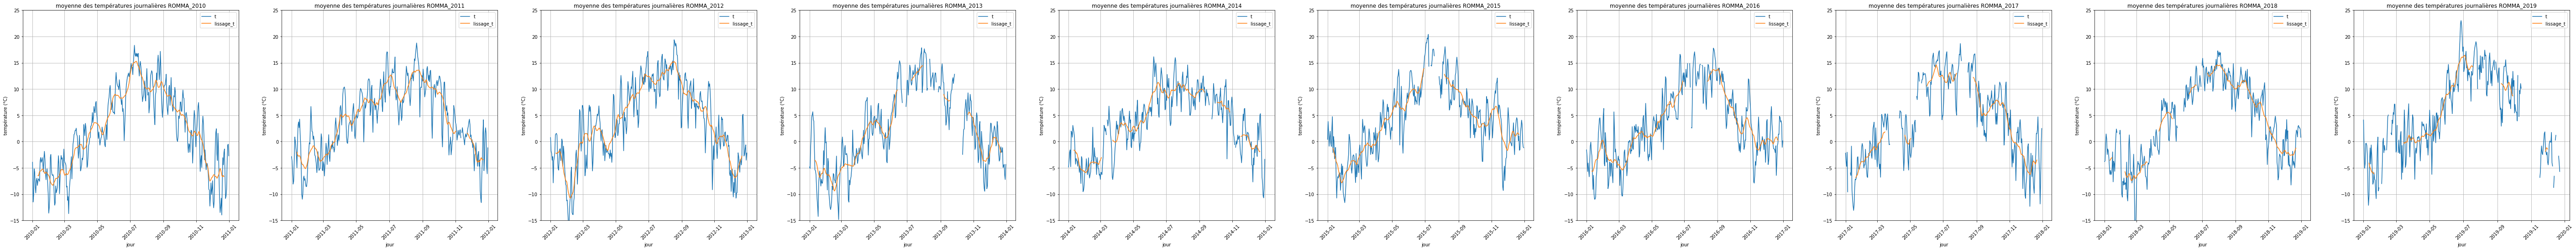

In [29]:
Graph(liste_df_romma ,x_units='jour', 
      y_units='température (°C)', y_min = -15, y_max = 25,
      title = 'moyenne des températures journalières ROMMA', columns= ['t'],plusieurs_graph = True,
      col_lissage = ['t'], val_lissage = 20, save = 'Température_ROMMA')

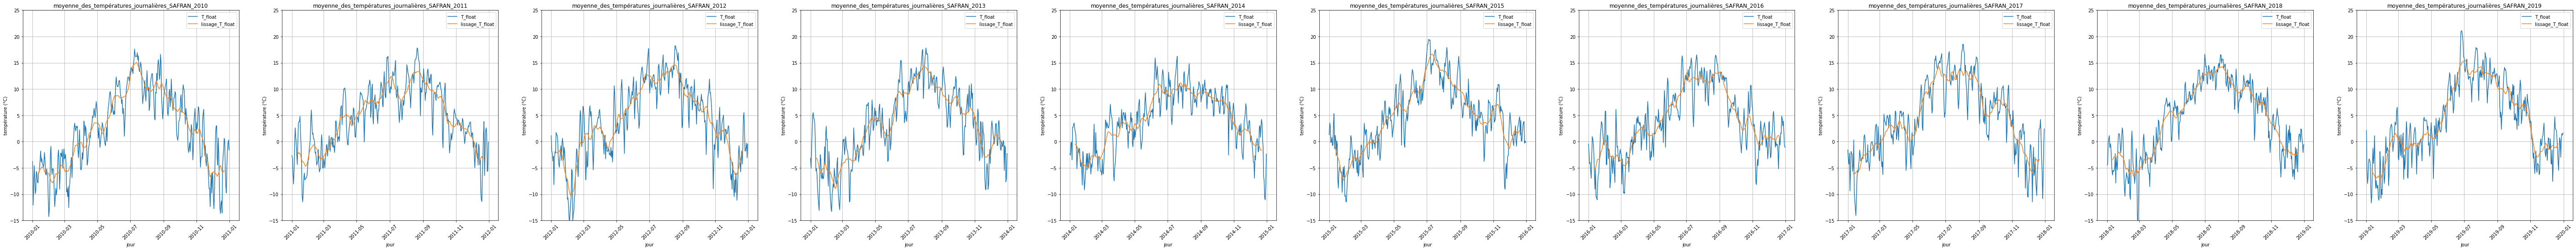

In [30]:
Graph(liste_df_safran ,x_units='jour', 
      y_units='température (°C)', y_min = -15, y_max = 25,
      title = 'moyenne_des_températures_journalières_SAFRAN', columns= ['T_float'],plusieurs_graph = True,
      col_lissage = ['T_float'], val_lissage = 20, save = 'Température_SAFRAN')

## III.2 - Détermination des précipitations solides et liquides pour ROMMA et SAFRAN et comparaison

Dans cette partie nous allons utiliser les colonnes de précipitation de nos DataFrame pour determiner quelle est la proportion de précipitation solide et liquide. Pour ce faire nous utiliserons la température. Si cette dernière est inferieur à 4°C (valeur arbitraire) alors les précipitations (si il y a des précipitations) seront solides. Sinon elles seront liquides.

* *Pour ROMMA*

In [31]:
pluie_neige('df_romma_temperature_precipitation_d.csv','t','precip', t_c=4)

'pluie_neige_df_romma_temperature_precipitation_d.csv'

In [32]:
liste_df_romma_pluie_neige = divise_année('pluie_neige_df_romma_temperature_precipitation_d',2010,2020)

* *Pour SAFRAN*

In [33]:
pluie_neige('df_safran.csv','T_float','Precip_float', t_c=4)

'pluie_neige_df_safran.csv'

In [34]:
liste_df_safran_pluie_neige = divise_année('pluie_neige_df_safran',2010,2020)

* *On affiche les graphiques*

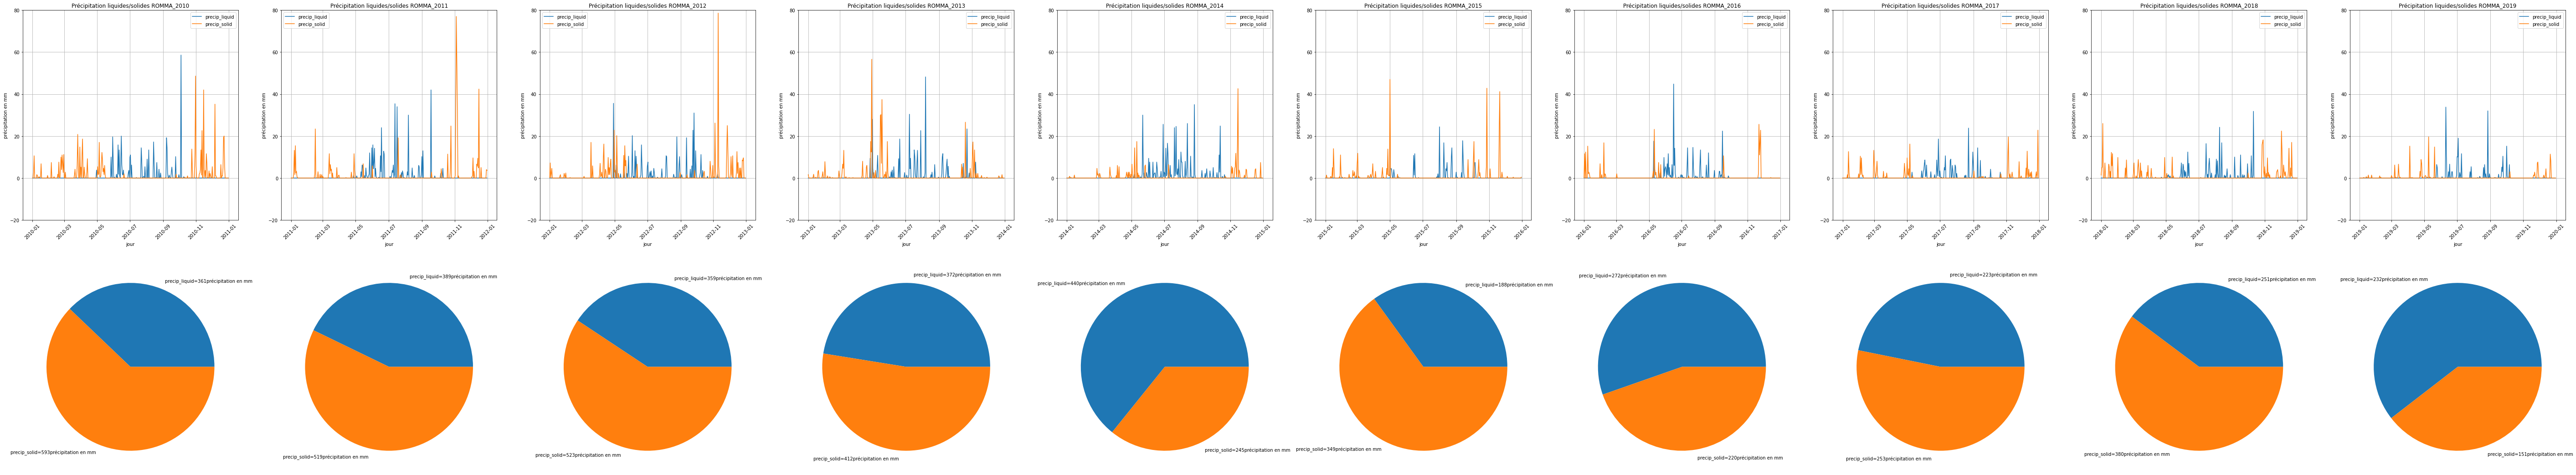

In [35]:
Graph(liste_df_romma_pluie_neige ,x_units='jour', y_units='précipitation en mm', 
      y_min = -20, y_max = 80, title = 'Précipitation liquides/solides ROMMA', 
      columns = ['precip_liquid', 'precip_solid'], plusieurs_graph = True, save='pluie_neige_ROMMA', 
      autre_graph='pie')

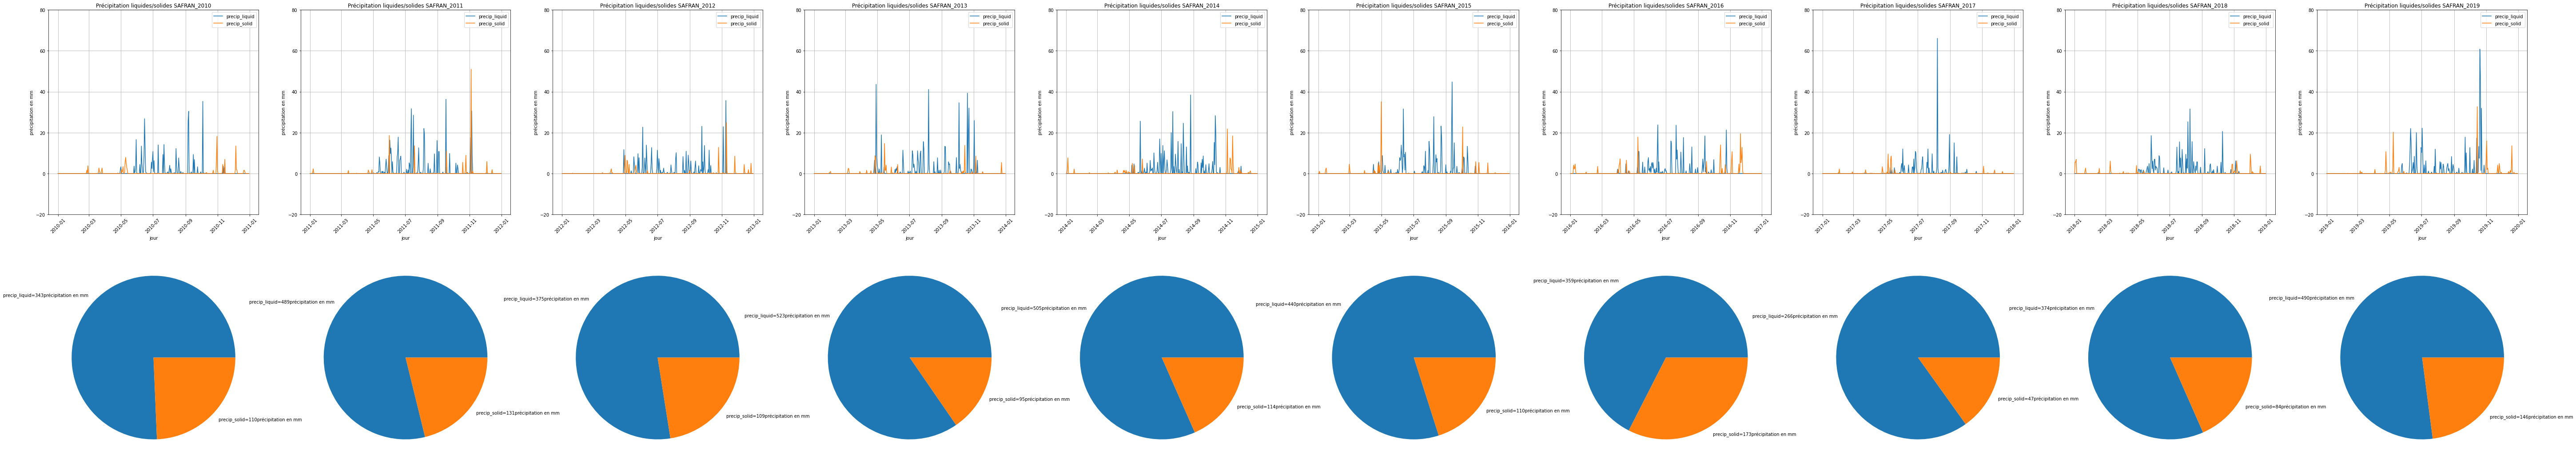

In [36]:
Graph(liste_df_safran_pluie_neige ,x_units='jour', y_units='précipitation en mm', 
      y_min = -20, y_max = 80, title = 'Précipitation liquides/solides SAFRAN', 
      columns = ['precip_liquid', 'precip_solid'], plusieurs_graph = True, save='pluie_neige_SAFRAN', 
      autre_graph='pie')

* **ROMMA**

>Persuadé que la station de mesure physique était plus fiable que le modèle numérique, nous avons remarqué l’acquisition de donnée sur la neige n’est pas si simple. Le pluviomètre à augets basculants n’est pas équipé de résistance pour faire fondre la neige récoltée, celle-ci est donc accumulée jusqu’à ce qu’elle puisse fondre, ce qui est responsable d’un décalage des précipitations dans le temps. Nous supposons également que les données de précipitations neigeuses peuvent être sous-estimées, car la neige accumulée dans le pluviomètre peut déborder ou s'enlever par le vent. 

* **SAFRAN** 

>Les données du modèle de météo France, s’appuient sur une analyse de mesure physique (Pression, température) pour extrapoler des résultats de précipitation, par rapport aux données de précipitation ROMMA, nous remarquons que les sommes de précipitation annuelles sont relativement constantes (aux alentours de 550/600 mm/an). La quantité de précipitation globale est également différente, qu’elles soient solides ou liquides, et se trouve généralement plus élevée pour la station ROMMA (1000 mm en 2010). Ces observations viennent réfuter notre hypothèse de départ sur la fiabilité des mesures de la station météo ROMMA, même si ces dernières peuvent être remises en cause, surtout en hiver, nous considérons les données de SAFRAN peu réalistes.


# IV - Albédo et hauteur de neige

## IV.1 Graphique de l'albédo et de la hauteur de neige en fonction de la date

Dans cette partie nous allons présenter les données d'albédo et de hauteur de neige de FluxAlp_NDVI.

* **La station FluxAlp**
>Cette station est une station de mesure des conditions météorologiques et des flux d’énergie et de matière. Pour effectuer notre étude de l'albédo nous allons croiser les données de hauteur de neige et d'albédo de cette station.


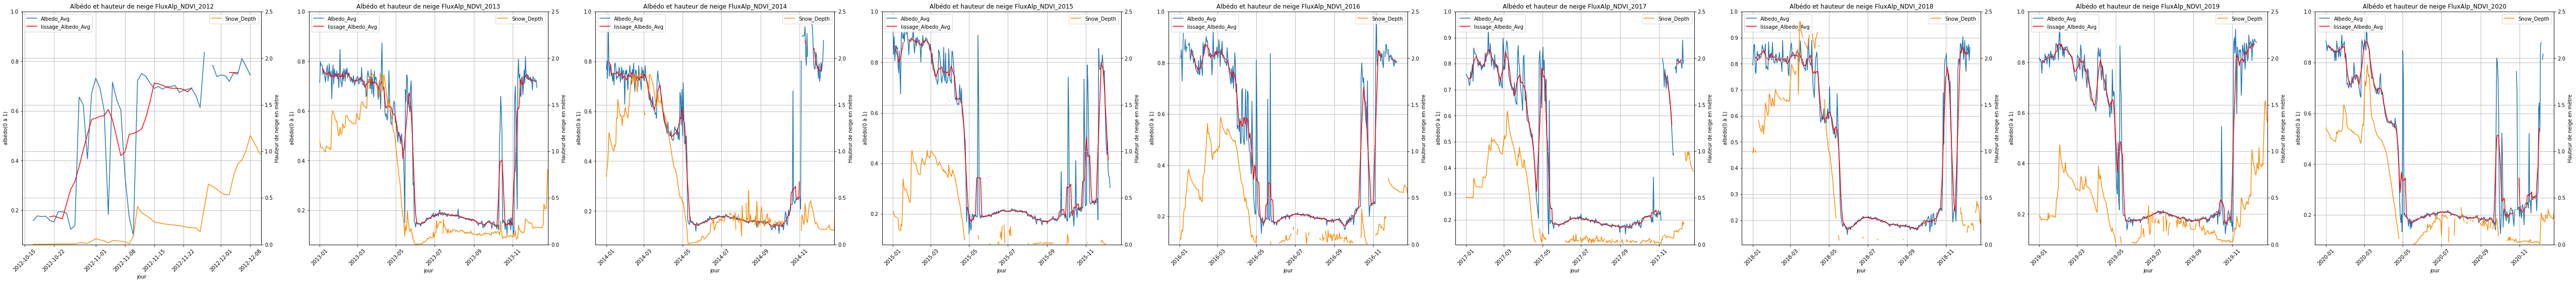

In [37]:
Graph(liste_df_FluxAlp_NDVI, 'jour', 'albédo(0 à 1)', y2_units = 'Hauteur de neige en mètre',
      y_max = 1, y2_max = 2.5, title = 'Albédo et hauteur de neige FluxAlp_NDVI', col_lissage = ['Albedo_Avg'], 
      val_lissage = 8,columns = ['Albedo_Avg', 'Snow_Depth'], plusieurs_graph=True, deux_ax = True, 
      start_year = 2012, save = 'Albédo_Neige_FluxAlp_NDI')

Comme attendu, l'albédo alterne en moyenne entre 0.8 l'hiver et 0.2 l'été en raison de la disparition du manteau neigeux à la fin du printemps.

## IV.2 Régression de la valeur de l'albédo entre deux hausses de la hauteur de neige

Dans cette partie nous allons identifier les hausses de hauteur de neige grâce aux données de FluxAlp_NDVI. Nous ne prendrons que les valeurs dont la date se situe entre le 1 décembre et la 30 Avril. Par définiton, entre deux hausses de hauteur de neige il y a une période de fonte, de potentielle baisse de la hauteur de neige. Notre objectif est donc d'enregistrer les périodes de fonte et d'observer la variation de l'albédo. Cependant, pour avoir des periodes de fonte significatives, nous avons établi que cette dernière devait être superieur à 5 jours et ne devait presenter aucune valeur maquante.

Nous avons décider d'utiliser les hauteurs de neige et non les données de précipitations solides définies précédemment. Comme expliqué plus haut, les valeurs de précipitations solides sont faussées par l'instrument de mesure. La mesure de la hauteur de neige est plus précise.

In [66]:
liste_df_fonte = []
d=2012
for name in liste_df_albedo_FluxAlp_NDVI :
    file = '../personnal_work/personnal_data/'+name
    df = pd.read_csv(file,sep=';', low_memory=False, parse_dates = True) 
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    
    l_Snow_Depth = list(df['Snow_Depth'])
    l_albedo = list(df['Albedo_Avg'])
    
    i = 0
    a = 1
    while a < len(l_albedo):
        if l_Snow_Depth[a-1] >= l_Snow_Depth[a] :
            a+=1

        else :
            if a-i > 5 :
                new_df = df[i:a]
                new_df = new_df.reset_index(drop=True)
                l_delta_time = [new_df.loc[1,'TIMESTAMP'] - df.loc[0,'TIMESTAMP']]
                
                nom = 'df_fonte_hiver_'+str(d)+'__date__'+str(df.loc[i,'TIMESTAMP'])+'_to_'+str(df.loc[a,'TIMESTAMP'])+'.csv'
                chemin = '../personnal_work/personnal_data/df_épisode_fonte/'+nom
                new_df.to_csv(chemin,sep =';')
            
                liste_df_fonte.append(nom)
            
            i=a
            a+=1
    d+=1

>Ce code nous permet de créer une liste de dataframe (liste_df_fonte) contenant la valeur de l'albédo et de la hauteur de neige en fonction des dates de la période de fonte. Ils sont enregistrés dans le dossier : /personnal_data/df_épisode_fonte. Cette liste de dataframe contient des périodes de fontes selon les critères que nous avons établi précédemment. Nous allons par la suite rassembler toutes les valeurs d'albédo en fonction de l'épisode de fonte dans un dataframe unique.

[14]

In [67]:
df_all_albedo_FluxAlp_NDVI = pd.DataFrame()

for i in range(0,len(liste_df_fonte)) :
    file = '../personnal_work/personnal_data/df_épisode_fonte/'+liste_df_fonte[i]
    df = pd.read_csv(file,sep=';', low_memory=False, parse_dates = True)
    df.drop('TIMESTAMP', axis = 1, inplace=True)
    df.drop('Snow_Depth', axis = 1, inplace=True)
    df_all_albedo_FluxAlp_NDVI = pd.concat([df_all_albedo_FluxAlp_NDVI, df['Albedo_Avg']], axis=1) 
    
    name_col = 'Albédo_'+str(i+1)
    df_all_albedo_FluxAlp_NDVI.rename(columns = {'Albedo_Avg': name_col}, inplace = True)
df_all_albedo_FluxAlp_NDVI.to_csv('../personnal_work/personnal_data/df_all_albedo_FluxAlp_NDVI.csv', sep=';')
df_all_albedo_FluxAlp_NDVI.head()

,Albédo_1,Albédo_2,Albédo_3,Albédo_4,Albédo_5,Albédo_6,Albédo_7,Albédo_8,Albédo_9,Albédo_10,...,Albédo_34,Albédo_35,Albédo_36,Albédo_37,Albédo_38,Albédo_39,Albédo_40,Albédo_41,Albédo_42,Albédo_43
0,0.7840,0.7455,0.749,0.717,0.697,0.7925,0.6450,0.732,0.9360,0.911,...,0.8525,0.7735,0.8525,0.8065,0.8840,0.8715,0.7180,0.8300,0.8595,0.7835
1,0.7840,0.7855,0.773,0.706,0.650,0.7405,0.6660,0.791,0.8300,0.924,...,0.8595,0.7260,0.7610,0.8900,0.8720,0.8820,0.7985,0.8280,0.8010,0.7380
2,0.7465,0.7085,0.733,0.704,0.588,0.7860,0.6305,0.720,0.9010,0.902,...,0.8620,0.7000,0.7295,0.8600,0.8465,0.8170,0.7720,0.8545,0.7980,0.7090
3,0.7640,0.7690,0.749,0.722,0.578,0.7680,0.6230,0.741,0.8055,0.877,...,0.8600,0.7740,0.7875,0.8820,0.8665,0.8350,0.7320,0.9170,0.7540,0.6970
4,0.7600,0.7525,0.754,0.694,0.589,0.7425,0.6170,0.795,0.8530,0.829,...,0.8380,0.7670,0.7790,0.8920,0.8680,0.8190,0.7390,0.8715,0.7300,0.6775


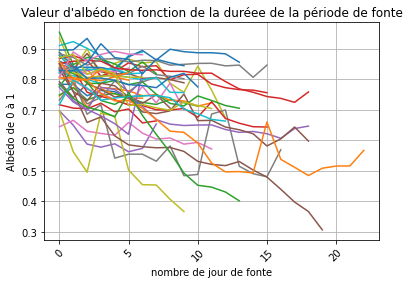

In [68]:
Graph(['df_all_albedo_FluxAlp_NDVI.csv'], x_units = 'nombre de jour de fonte', 
      y_units = 'Albédo de 0 à 1', title="Valeur d'albédo en fonction de la duréee de la période de fonte", 
      legend=False)

>*Nous avons donc réussi à tracer l'évolution de la valeur de l'albédo pour toutes les périodes de fonte jugées significatives et pertinentes.*

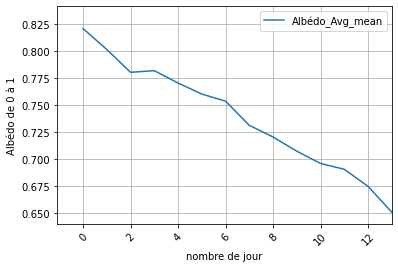

In [71]:
Graph([valeur_moyenne_albédo], 
      x_units = 'nombre de jour', 
      y_units = 'Albédo de 0 à 1', 
      x_max = 13, y_min = 0.64, columns=['Albédo_Avg_mean'],
      csv=False)

>Pour obtenir ce graphique nous avons simplement effectué la moyenne de la valeur d'albédo pour chaque index du dataframe : df_all_albedo_FluxAlp_NDVI. Au vu du peu de valeurs que nous avons après du 13ème jour nous avons décidé de faire stoper la courbe ici. Cette représentation n'est pas forcément la plus adaptée pour avoir le coéfficient de regression de l'albédo au cours du temps. Cependant elle nous permet de voir comment se comporte notre échantillons et également de dégrossir le graphique précédent (un peu chargé).

>L’albédo de la neige fraîche varie de 0,65 à 0,95. Cette variabilité de résultats nous indique que l’albédo est affecté pas plusieurs facteurs. D’après la bibliographie, la température de la surface de la neige, la taille des grains, et le taux d’humidité sont des paramètres qui influencent l’albédo de la neige fraîche (Chen et al. 2014).
Une autre référence (Baker, Skaggs, et Ruschy 1991) met en évidence l’importance de l’épaisseur de la neige. En effet le rayonnement solaire peut pénétrer un manteau neigeux jusqu’à une certaine profondeur. L’absorption du rayonnement visible par le sol et la végétation sous-jacents peut influencer l’albédo de la surface de la neige lorsque le manteau neigeux n’est pas assez épais, d’après cette référence, 5 à 15 cm sont nécessaires pour masquer l’influence de la surface sous-jacente.
Nous avons recensé une quarantaine d’évènements neigeux sur la période 2012-2021, en réalité il y en a eu plus, mais nous avons pris soin d’enlever les épisodes dont le résultat était incohérent (défaut de capteur). Au vu de ce faible nombre d’observation, nous avons caractérisé la variation temporelle de l’albédo de la neige fraîche. Il aurait été intéressant d’étudier l’impact du taux l’humidité. Nous noterons simplement que nous avons une grande quantité d’évènements en mars, considéré comme le début de la période de fonte où le taux d’humidité de la neige augmente et l’albédo décroît plus rapidement.



In [59]:
valeur_moyenne_albédo = pd.DataFrame(df_all_albedo_FluxAlp_NDVI.mean(axis = 1),columns={'Albédo_Avg_mean'})
valeur_moyenne_albédo.reset_index(inplace=True)
valeur_moyenne_albédo.head()

,index,Albédo_Avg_mean
0,0,0.820453
1,1,0.801093
2,2,0.780012
3,3,0.781523
4,4,0.770140


In [60]:
res = stats.linregress(valeur_moyenne_albédo.iloc[:,0], valeur_moyenne_albédo.iloc[:,1])
print(res.slope)

-0.014845432949210695


## IV.3 Coefficient de régression de l'albédo

Nous allons ici calculer pour chaque courbe d'albédo du graphique :"Valeur d'albédo en fonction de la période de fonte" le coefficent directeur de sa courbe de tendance et les mettre dans un dataframe.

In [43]:
df_coefficient_régression_albédo = pente_regression_albedo(liste_df_fonte)
df_coefficient_régression_albédo.head()

,pente_albedo_regression
0,-0.010000
1,-0.002500
2,-0.004214
3,-0.007673
4,-0.008869


In [44]:
d = {'mean': df_coefficient_régression_albédo['pente_albedo_regression'].mean(), 
     'sd': df_coefficient_régression_albédo['pente_albedo_regression'].std(), 
     'min': df_coefficient_régression_albédo['pente_albedo_regression'].min(), 
     'max': df_coefficient_régression_albédo['pente_albedo_regression'].max()}
df_stat = pd.DataFrame(d, index={'valeur statistique de df coefficient régression albédo'})
df_stat

,mean,sd,min,max
valeur statistique de df coefficient régression albédo,-0.008211,0.007892,-0.03123,0.008625


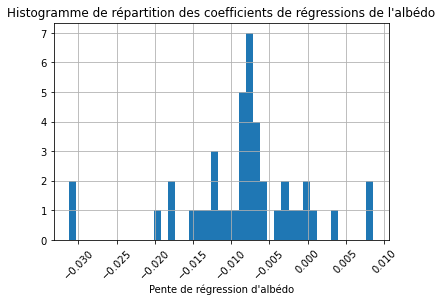

In [45]:
Graph([df_coefficient_régression_albédo], x_units="Pente de régression d'albédo", y_units='', csv=False, 
      title="Histogramme de répartition des coefficients de régressions de l'albédo", 
      columns=['pente_albedo_regression'], autre_graph='hist', 
      save = 'Histogramme_coefficient_regression_albedo')

>D’après les observations du site du col de Porte, l’albédo diminue plus rapidement dans les premières heures après la chute de neige, on considère qu’elle suit une courbe de décroissance exponentielle avant de retrouver une tendance linéaire. Dans notre cas d’étude nous avons remarqué que la régression linéaire entre la chute de neige et le premier jour est quatre fois plus importante qu’entre le premier et le deuxième jour après la chute de neige, les jours suivant la régression tant à augmenter dans le temps. Encore une fois nous observons une régression linéaire moyenne (-0,008/jour) du même ordre de grandeur par rapport à la littérature.

## IV.4 Identification d'un épisode de précipitations sahariennes

Nous connaissons les dates de deux événements de précipitations sahariennes :**

* *Le 3 et 4 avril 2018 -> cependant nous n'avons aucune données pour le 4 fevrier et il y a beaucoup de trous dans les données pour cette periode. Il est donc impossible d'utiliser cet événement.*
    
* *Le 6 fevrier 2021 -> Nous disposons de données à partir du 2 fevrier 2021. Cette date correspond au début d'un épisode de fonte qui durera jusqu'au 6 fevrier. Nous pouvons donc isoler dans un dataframe les dates du 2 au 6 fevrier et voir comme l'albédo se comporte notamment le 6. Enfin, nous pouront calculer la pente de la courbe de tendance de cet événement et la comparer avec la distribution normale et ainsi voir comme la précipitation Saharienne à impacter cette pente.*

Cet épisode présente une durée de fonte plus courte que 6 jours (période que l'on à determinée précédement pour avoir des périodes de fonte plus significative et donc une regression de l'albédo plus marquée). Ainsi cet évenement ne font pas partie des données utilisées dans toute la partie IV.3. Ceci va nous permettre de comparer la répartition des coefficents de régression de l'albédo avec et sans cet épisode saharien et d'observer de potentielles différences.

[18]

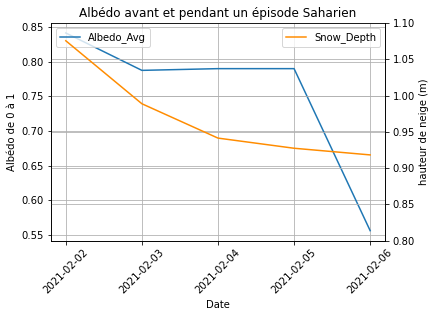

In [46]:
file = '../personnal_work/personnal_data/df_albedo_FluxAlp_NDVI_2020.csv'
df = pd.read_csv(file, sep=';', low_memory=False, index_col=[0])
df_sahara = df['2021-02-02':'2021-02-06']

Graph([df_sahara], x_units = 'Date', y_units = 'Albédo de 0 à 1', deux_ax = True, 
      y2_units = 'hauteur de neige (m)', y2_min = 0.8, y2_max = 1.1, columns = ['Albedo_Avg','Snow_Depth'], 
      csv = False, title = 'Albédo avant et pendant un épisode Saharien', save = 'albedo_sahara')

In [47]:
print("Valeur du coefficient de régression de l'albédo avant et pendant l'épisode de précipitation sahrienne :")
print(float(df_sahara.iloc[0,0]))

Valeur du coefficient de régression de l'albédo avant et pendant l'épisode de précipitation sahrienne :
0.8414999999999999


>**Rappelons que la valeur moyenne des coefficients de régression de l'albédo est de -0.008211. Lors de l'épisode de précipitations sahariennes, ce coefficent est de -0.057. Soit une augmentation d'un facteur 7 du coefficient de régression de l'albedo.**

>*Ce graphique contenient la courbe d'albédo et de hauteur de neige pour les dates du 2 au 6 fevrier 2022 (date de l'épisode Saharien). Nous observons une forte baisse de l'albédo le 6 fevrier. Pour vérifier si cette baisse brutale est due au seul veillissement de la neige, nous allons tracer un nouveau graphique de même de même durée, à des dates similaires un an avant et avec des hauteurs de neige proches.*

[19]

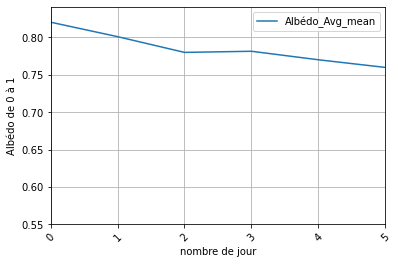

In [76]:
Graph([valeur_moyenne_albédo], 
      x_units = 'nombre de jour', 
      y_units = 'Albédo de 0 à 1', x_min = 0,
      x_max = 5, y_min = 0.55, 
      columns=['Albédo_Avg_mean'],
      csv=False)

>*Pour tracer ce graphique nous avons bien fait attention à prendre une date de départ (le 29 janvier 2020) contenant un hausse de la hauteur de neige, traduisant donc une chute de neige fraiche. Le delta Time des deux graphiques sont égaux, alors le veillisement de la neige est le même. Nous observons que pour un même veillissement l'albédo chute de façon bien plus significative lors de l'épisode de précipitations sahariennes alors qu'avant cet épisode les valeurs d'albédo on une tendance proche.*

>*Pour être vraiment sur de la significativité de la baisse d'albédo le 6 fevrier 2021 nous allons faire un T-test. Pour effectuer ce test nous aurons besoin des deux listes d'albédo de nos deux graphiques précédents.*

[20]

In [49]:
X1 = list(df_compare['Albedo_Avg'])
X2 = list(df_sahara['Albedo_Avg'])

T_test = stats.ttest_ind(X1,X2) ; print(T_test)

Ttest_indResult(statistic=1.7653387792808406, pvalue=0.11550368503590748)


>*Ce T-Test ne montre finalement pas de différences signifacative entre les deux échantillions car la pvalue est superieur à 0.05. Cependant ceci peut s'expliquer par le fait que beaucoup de valeurs des deux échantillions sont proches, notamment les valeurs du df_sahara avant les précipitations sahariennes.*

>Nous allons tracer un histogramme pour montrer l'impacte de la valeur de pente de la tendance de régression d'albédo.

[21]

In [50]:
df_sahara.reset_index(inplace=True)
df_sahara.to_csv('../personnal_work/personnal_data/df_épisode_fonte/df_sahara_6_fevrier.csv', sep = ';')
df_sahara=pente_regression_albedo(['df_sahara_6_fevrier.csv'])

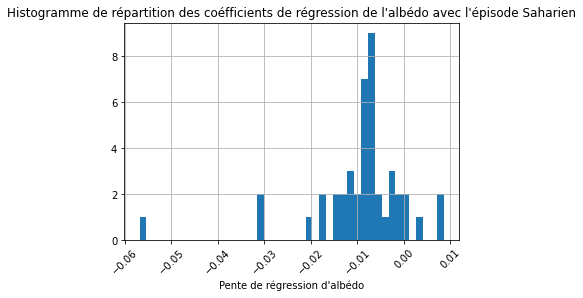

In [51]:
df_coefficient_régression_albédo_sahara = df_coefficient_régression_albédo.append(df_sahara,ignore_index=True)
Graph([df_coefficient_régression_albédo_sahara], x_units="Pente de régression d'albédo", y_units='', csv=False, 
      title="Histogramme de répartition des coéfficients de régression de l'albédo avec l'épisode Saharien", 
      columns=['pente_albedo_regression'], autre_graph = 'hist',
      save = 'Histogramme_coefficient_regression_albedo+épisode_sahara')

In [52]:
df_tendance_par_hiver = group_tendance(liste_df_albedo_FluxAlp_NDVI)
df_tendance_par_hiver_sahara = group_tendance(liste_df_albedo_FluxAlp_NDVI, sahara=2020)

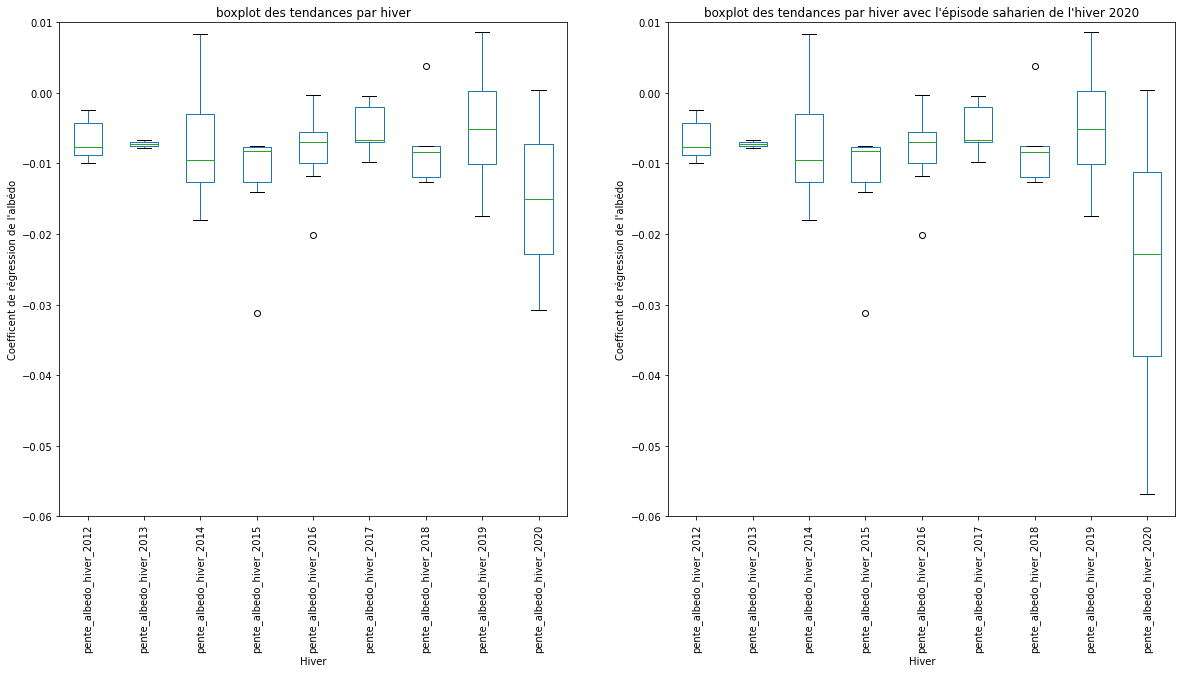

In [53]:
Graph([df_tendance_par_hiver,df_tendance_par_hiver_sahara], x_units = 'Hiver', 
      y_units = "Coefficent de régression de l'albédo", y_min=-0.06, y_max=0.01, autre_graph='boxplot',
      l_title = ['boxplot des tendances par hiver',
                 "boxplot des tendances par hiver avec l'épisode saharien de l'hiver 2020"], 
      csv = False, plusieurs_graph=True)

Conclusion ??

[22]

# V - Conclusion

éclatez vous mdrr

[23]